## Importing libraries


In [1]:

import os
import PIL
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## Mount google drive
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:


os.getcwd()



'/content'

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)



2239
118



Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.
Create a dataset

Define some parameters for the loader:


In [6]:
### Creating dataset parameters
batch_size = 32
img_height = 180
img_width = 180



Use 80% of the images for training, and 20% for validation.


In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data
Todo, create a code to visualize one instance of all the nine classes present in the dataset

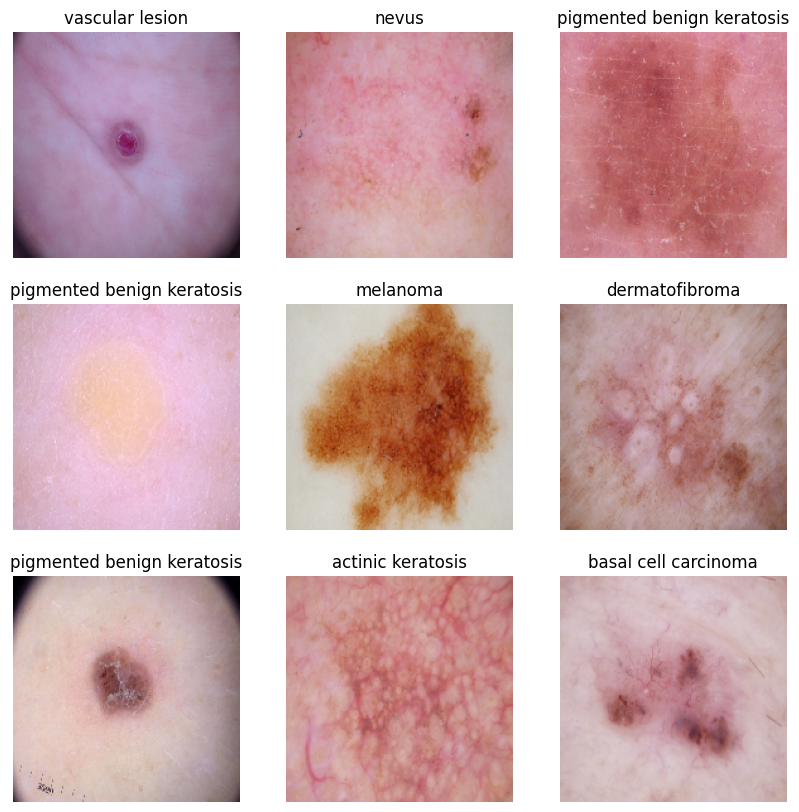

In [10]:
### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")



The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [13]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Create the model

Todo:
     Create a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [17]:
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
rescale = Rescaling(scale=1./255)
# Use the map method to apply the Rescaling layer to each image in the dataset
normalised_ds = train_ds.map(lambda x, y: (rescale(x), y))

In [18]:
image_batch, labels_batch = next(iter(normalised_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.085316084 0.704098


In [20]:
len(image_batch)

32

In [21]:
# getting the number of classes in the dataset
num_classes = len(class_names)

# building the model with keras Sequential with relu as activation function
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

Choose an appropirate optimiser and loss function for model training

In [22]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [23]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

Train the model


In [24]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 20s 164ms/step - loss: 2.0828 - accuracy: 0.2472 - val_loss: 1.8898 - val_accuracy: 0.3400
Epoch 2/20
56/56 [==============================] - 0s 9ms/step - loss: 1.7340 - accuracy: 0.3772 - val_loss: 1.6254 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 0s 9ms/step - loss: 1.5767 - accuracy: 0.4414 - val_loss: 1.5185 - val_accuracy: 0.4743
Epoch 4/20
56/56 [==============================] - 0s 9ms/step - loss: 1.4241 - accuracy: 0.4927 - val_loss: 1.4807 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 0s 9ms/step - loss: 1.3060 - accuracy: 0.5368 - val_loss: 1.4637 - val_accuracy: 0.5213
Epoch 6/20
56/56 [==============================] - 0s 9ms/step - loss: 1.2396 - accuracy: 0.5541 - val_loss: 1.4198 - val_accuracy: 0.4989
Epoch 7/20
56/56 [==============================] - 0s 9ms/step - loss: 1.1768 - accuracy: 0.5642 - val_loss: 1.4543 - val_accuracy: 0.5414
Epoch 8/20
56/56 


Visualizing training results


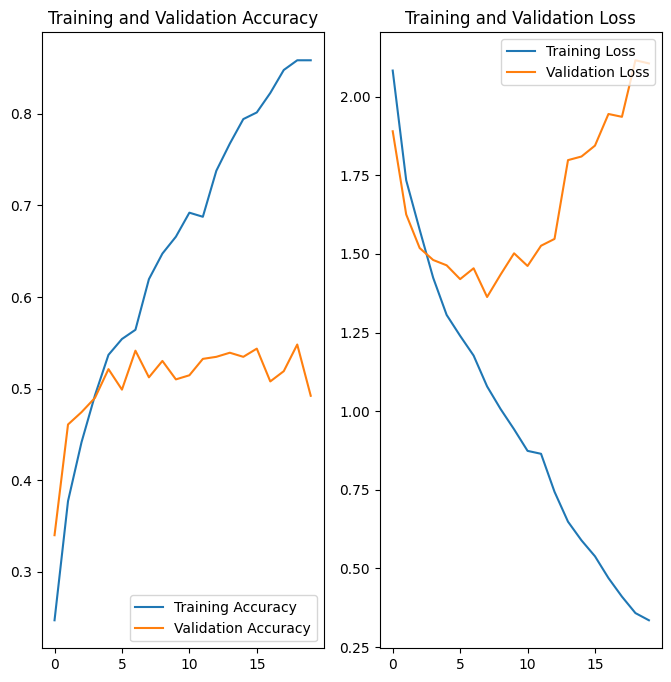

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Write your findings here

Findings

    Validation accuracy is slightly higher in the initial stage and it hovers arround 0.55 level
    Validation Loss is very high compare to training loss.

Based on observation , model is overfitting


In [26]:
# As the model is overfitting, using agumentation to reduce the it
# using random flip, rotate and zoom for agumentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)])

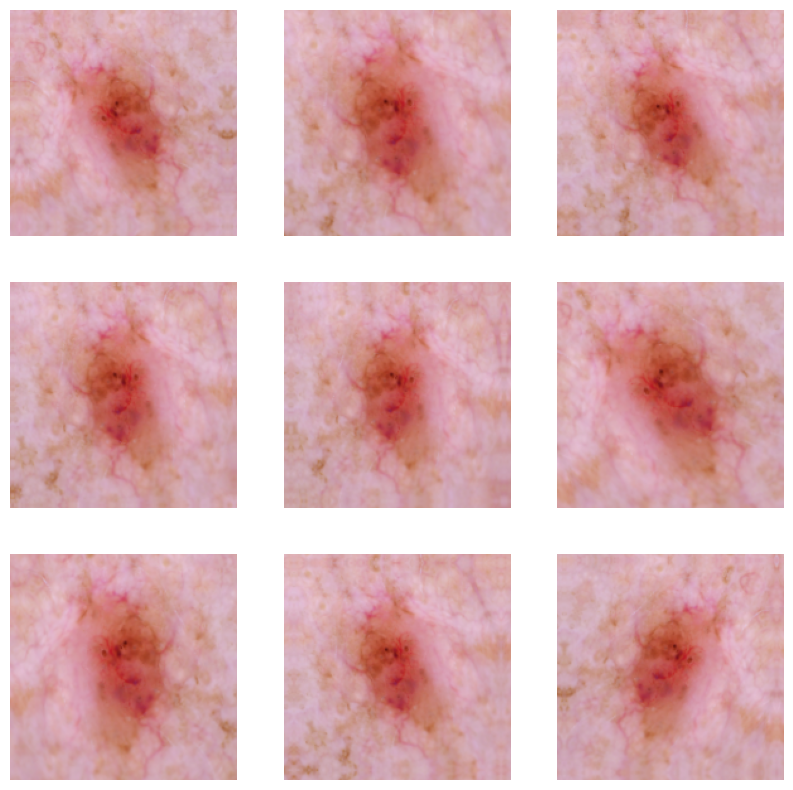

In [27]:


#visualize how your augmentation strategy works for one instance of training image.
# setting the output image size
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")




Create the model, compile and train the model

In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# Let's add some dropout layers to the model as our model is overfitting
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


Compiling the model


In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# printing the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  


Training the model


In [30]:


## Your code goes here, note: train your model for 20 epochs
# We are not changing the epochs count for the second model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)



Epoch 1/20
56/56 [==============================] - 3s 13ms/step - loss: 2.1115 - accuracy: 0.2266 - val_loss: 1.9471 - val_accuracy: 0.2729
Epoch 2/20
56/56 [==============================] - 1s 10ms/step - loss: 1.8169 - accuracy: 0.3326 - val_loss: 1.5594 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 1s 11ms/step - loss: 1.5240 - accuracy: 0.4576 - val_loss: 1.4571 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 1s 11ms/step - loss: 1.4575 - accuracy: 0.4821 - val_loss: 1.3953 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 1s 11ms/step - loss: 1.4058 - accuracy: 0.4900 - val_loss: 1.4547 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 1s 11ms/step - loss: 1.3593 - accuracy: 0.5218 - val_loss: 1.3246 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 1s 11ms/step - loss: 1.3146 - accuracy: 0.5329 - val_loss: 1.3544 - val_accuracy: 0.5459
Epoch 8/20
56


Visualizing the results


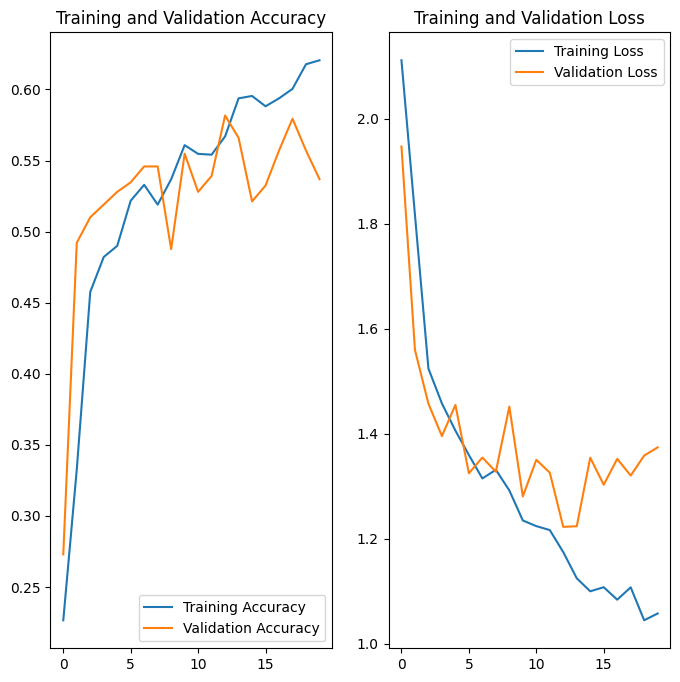

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



Findings

    We can see that Training and validation accuracy are following the same trend and at 0.55 validation accuracy is fluctuating

    We observe the Validation and Training loss are also following the same trend.

    there is some misleading in the validation results and training results, this might be caused by class imbalance




Todo:
 Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [33]:
## Your code goes here.
## original_df - > path_list, lesion_list
path_list=[]
lesion_list=[]

for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
1,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
2,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
3,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
4,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,vascular lesion
2235,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,vascular lesion
2236,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,vascular lesion
2237,/content/gdrive/MyDrive/CNN_Assignment/Skin ca...,vascular lesion


In [36]:
original_df["Label"].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

<BarContainer object of 9 artists>

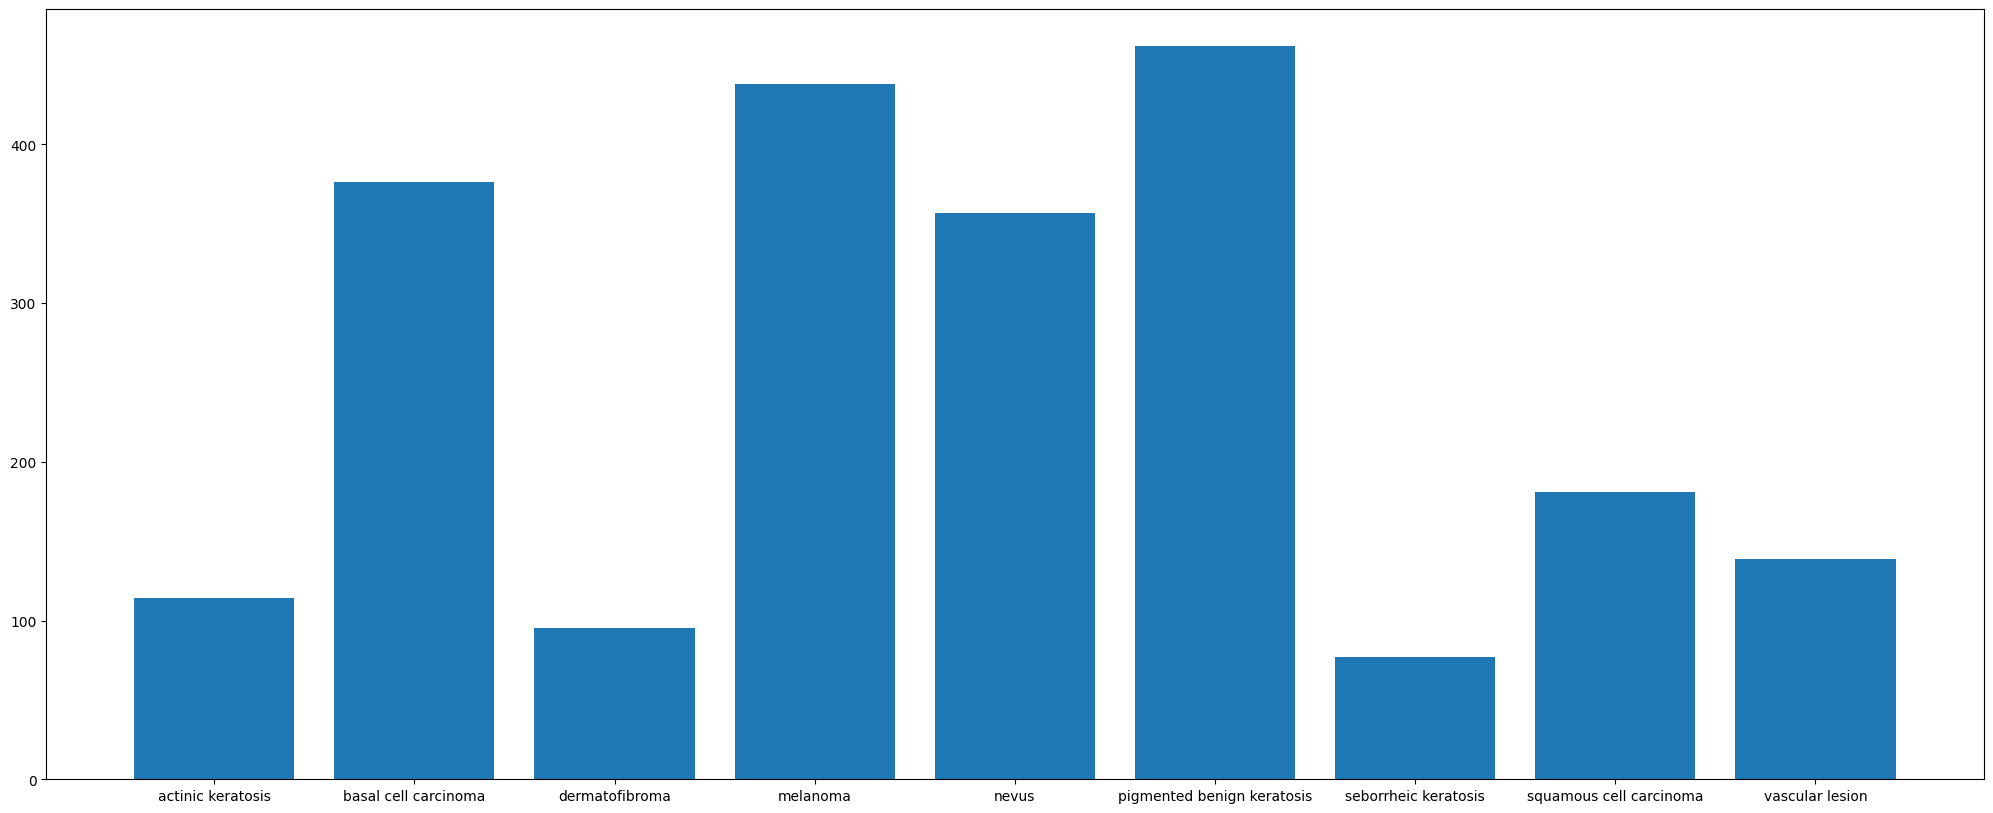

In [37]:
# glob('./Skin cancer ISIC The International Skin Imaging Collaboration/train/*/*')
# './Skin cancer ISIC The International Skin Imaging Collaboration/train\\actinic keratosis\\ISIC_0025780.jpg'
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)


findings here:
- seborrheic keratosis has the least number of samples
- below classes dominate the data in terms proportionate number of samples: 
       *   pigmented benign
       *   melanoma
       *   basal cell carcinoma
       *   nevus

  


Todo: Rectify the class imbalance
Context: You can use a python package known as Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [38]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




To use Augmentor, the following general procedure is followed:
1.  Instantiate a Pipeline object pointing to a directory containing your initial image data set.
2.   Define a number of operations to perform on this data set using your Pipeline object.
3.   Execute these operations by calling the Pipeline’s sample() method.





    
    



In [40]:
import Augmentor
path_to_training_dataset= "/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F120043C190>: 100%|██████████| 500/500 [00:04<00:00, 118.54 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F12004356D0>: 100%|██████████| 500/500 [00:04<00:00, 121.39 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F12004750A0>: 100%|██████████| 500/500 [00:04<00:00, 124.04 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F120A407880>: 100%|██████████| 500/500 [00:18<00:00, 26.79 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F12004EB250>: 100%|██████████| 500/500 [00:17<00:00, 29.14 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F120036E8B0>: 100%|██████████| 500/500 [00:04<00:00, 115.34 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1200435B80>: 100%|██████████| 500/500 [00:08<00:00, 61.44 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1200694490>: 100%|██████████| 500/500 [00:04<00:00, 120.64 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1200462220>: 100%|██████████| 500/500 [00:04<00:00, 124.07 Samples/s]




Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.


In [41]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500



Lets see the distribution of augmented data after adding new images to the original training data.


In [42]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [44]:
dataframe_augmented = dict(zip(path_list, lesion_list_new))

In [45]:
df2 = pd.DataFrame(list(dataframe_augmented.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-45-8adb4bac99af>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [46]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64



So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.



Todo: Train the model on the data created using Augmentor



Todo: Create a training dataset


In [47]:
data_dir_train= "/content/gdrive/MyDrive/CNN_Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed=123,
            validation_split = 0.2,
            subset = "training" ## Todo choose the correct parameter value, so that only training data is refered to,,
          ,image_size=(img_height, img_width),
            batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Todo: Create a validation dataset

In [48]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train,
            seed=123,
            validation_split = 0.2,
            subset = "validation" ## Todo choose the correct parameter value, so that only training data is refered to,,
          ,image_size=(img_height, img_width),
            batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.



Todo: Create your model (make sure to include normalization)


In [49]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])


Todo: Compile your model (Choose optimizer and loss function appropriately)


In [50]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
# model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [52]:
##Train model
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs)

Epoch 1/30
169/169 [==============================] - 13s 64ms/step - loss: 2.0026 - accuracy: 0.2311 - val_loss: 1.6767 - val_accuracy: 0.3816
Epoch 2/30
169/169 [==============================] - 11s 61ms/step - loss: 1.6098 - accuracy: 0.3800 - val_loss: 1.5142 - val_accuracy: 0.4358
Epoch 3/30
169/169 [==============================] - 11s 61ms/step - loss: 1.4762 - accuracy: 0.4345 - val_loss: 1.4293 - val_accuracy: 0.4573
Epoch 4/30
169/169 [==============================] - 11s 61ms/step - loss: 1.4248 - accuracy: 0.4581 - val_loss: 1.4626 - val_accuracy: 0.4551
Epoch 5/30
169/169 [==============================] - 10s 60ms/step - loss: 1.3483 - accuracy: 0.4796 - val_loss: 1.2910 - val_accuracy: 0.5115
Epoch 6/30
169/169 [==============================] - 11s 61ms/step - loss: 1.3319 - accuracy: 0.4952 - val_loss: 1.3068 - val_accuracy: 0.5145
Epoch 7/30
169/169 [==============================] - 11s 61ms/step - loss: 1.2937 - accuracy: 0.5117 - val_loss: 1.2145 - val_accuracy:

Visualize the results

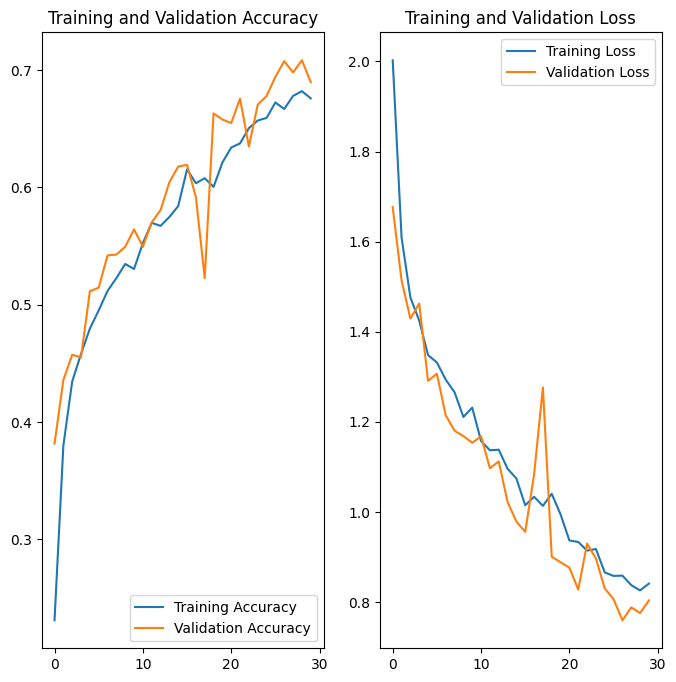

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Todo: Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Yes class rebalance helped in getting rid of the overfitting.

As you can see from the above as the training accuracy increased validation accuracy is also increasing